In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
from torch_geometric.nn import GATConv, LayerNorm
from imblearn.over_sampling import SMOTE
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

import random

In [2]:
# Đọc dataset
file_path = r'..\data\preprocess\encoded_dataset.csv'
df = pd.read_csv(file_path)

df = df.sample(2000) # Lấy ngẫu nhiên 2000 dòng dữ liệu

print(df.columns)
print(df['damage'].value_counts())
print(df['damage'].unique())

Index(['traffic_control_device', 'weather_condition', 'lighting_condition',
       'first_crash_type', 'trafficway_type', 'alignment',
       'roadway_surface_cond', 'road_defect', 'crash_type',
       'intersection_related_i', 'damage', 'prim_contributory_cause',
       'num_units', 'most_severe_injury', 'injuries_total', 'injuries_fatal',
       'injuries_incapacitating', 'injuries_non_incapacitating',
       'injuries_reported_not_evident', 'injuries_no_indication', 'crash_hour',
       'crash_day_of_week', 'crash_month'],
      dtype='object')
damage
2    1391
1     415
0     194
Name: count, dtype: int64
[0 2 1]


In [3]:
# Khởi tạo đồ thị
G = nx.Graph()

# Thêm nút cho mỗi vụ tai nạn (dựa trên index)
for index, row in df.iterrows():
    G.add_node(index,
               traffic_control_device=row['traffic_control_device'],
               weather_condition=row['weather_condition'],
               lighting_condition=row['lighting_condition'],
               first_crash_type=row['first_crash_type'],
               trafficway_type=row['trafficway_type'],
               alignment=row['alignment'],
               roadway_surface_cond=row['roadway_surface_cond'],
               road_defect=row['road_defect'],
               crash_type=row['crash_type'],
               intersection_related_i=row['intersection_related_i'],
               damage=row['damage'],
               prim_contributory_cause=row['prim_contributory_cause'],
               num_units=row['num_units'],
               most_severe_injury=row['most_severe_injury'],
               injuries_total=row['injuries_total'],
               injuries_fatal=row['injuries_fatal'],
               injuries_incapacitating=row['injuries_incapacitating'],
               injuries_non_incapacitating=row['injuries_non_incapacitating'],
               injuries_reported_not_evident=row['injuries_reported_not_evident'],
               injuries_no_indication=row['injuries_no_indication'],
               crash_hour=row['crash_hour'],
               crash_day_of_week=row['crash_day_of_week'],
               crash_month=row['crash_month'])

# Hàm kiểm tra điều kiện kết nối giữa hai vụ tai nạn
def is_similar(accident1, accident2):
    # Các điều kiện tương tự dựa trên các đặc trưng quan trọng
    time_diff = abs(accident1['crash_hour'] - accident2['crash_hour']) <= 1
    same_month = accident1['crash_month'] == accident2['crash_month']
    same_day_of_week = accident1['crash_day_of_week'] == accident2['crash_day_of_week']
    same_trafficway = accident1['trafficway_type'] == accident2['trafficway_type']
    same_crash_type = accident1['first_crash_type'] == accident2['first_crash_type']
    same_injury_no_indication = accident1['injuries_no_indication'] == accident2['injuries_no_indication']

    # Kết nối nếu ít nhất một điều kiện tương tự
    return (time_diff or same_month or same_day_of_week or same_trafficway or
            same_crash_type or same_injury_no_indication)

# Thêm các cạnh dựa trên tính tương đồng
for u, v in combinations(G.nodes(data=True), 2):
    if is_similar(u[1], v[1]):
        G.add_edge(u[0], v[0])

print("Đồ thị G đã được tạo với", G.number_of_nodes(), "nút và", G.number_of_edges(), "cạnh.")

Đồ thị G đã được tạo với 2000 nút và 1436311 cạnh.


In [11]:
# Degree Centrality
degree_centrality = nx.degree_centrality(G)
# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)
# Closeness Centrality
closeness_centrality = nx.closeness_centrality(G)

# Top 5 nút trung tâm theo degree
top5_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 nút Degree Centrality cao nhất:")
for node, centrality in top5_degree:
    print(f"Nút {node} - Degree Centrality: {centrality:.4f}")

# Top 5 nút có betweeness centrality cao nhất
top5_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 nút Betweenness Centrality cao nhất:")
for node, centrality in top5_betweenness:
    print(f"Nút {node} - Betweenness Centrality: {centrality:.6f}")

#Top 5 nút có closeness centrality cao nhất 
top5_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 nút Closeness Centrality cao nhất:")
for node, centrality in top5_closeness:
    print(f"Nút {node} - Closeness Centrality: {centrality:.6f}")



Top 5 nút Degree Centrality cao nhất:
Nút 190525 - Degree Centrality: 0.8724
Nút 15986 - Degree Centrality: 0.8714
Nút 102339 - Degree Centrality: 0.8689
Nút 194407 - Degree Centrality: 0.8679
Nút 66679 - Degree Centrality: 0.8669

Top 5 nút Betweenness Centrality cao nhất:
Nút 175330 - Betweenness Centrality: 0.000194
Nút 192318 - Betweenness Centrality: 0.000194
Nút 110212 - Betweenness Centrality: 0.000193
Nút 118586 - Betweenness Centrality: 0.000191
Nút 125986 - Betweenness Centrality: 0.000191

Top 5 nút Closeness Centrality cao nhất:
Nút 190525 - Closeness Centrality: 0.886868
Nút 15986 - Closeness Centrality: 0.886082
Nút 102339 - Closeness Centrality: 0.884122
Nút 194407 - Closeness Centrality: 0.883341
Nút 66679 - Closeness Centrality: 0.882561


In [ ]:
jaccard_scores = list(nx.jaccard_coefficient(G))
# Jaccard score giữa 10 cặp nút đầu tiên
print("\nVí dụ Jaccard Similarity (10 cặp bất kỳ):")
for u, v, score in random.sample(jaccard_scores, 10):
    print(f"({u}, {v}) -> similarity = {score:.4f}")


Ví dụ Jaccard Similarity (10 cặp bất kỳ):
(205578, 127137) -> similarity = 0.4935
(42131, 118586) -> similarity = 0.6081
(117055, 208320) -> similarity = 0.3897
(35894, 110468) -> similarity = 0.5245
(67277, 182798) -> similarity = 0.4294
(1186, 45714) -> similarity = 0.5590
(35350, 203581) -> similarity = 0.5227
(90674, 120567) -> similarity = 0.5454
(78960, 114165) -> similarity = 0.4537
(108550, 14909) -> similarity = 0.4690



Tổng số nút đã được lan truyền từ nút 1415: 2000
Độ sâu lớn nhất đạt được: 2


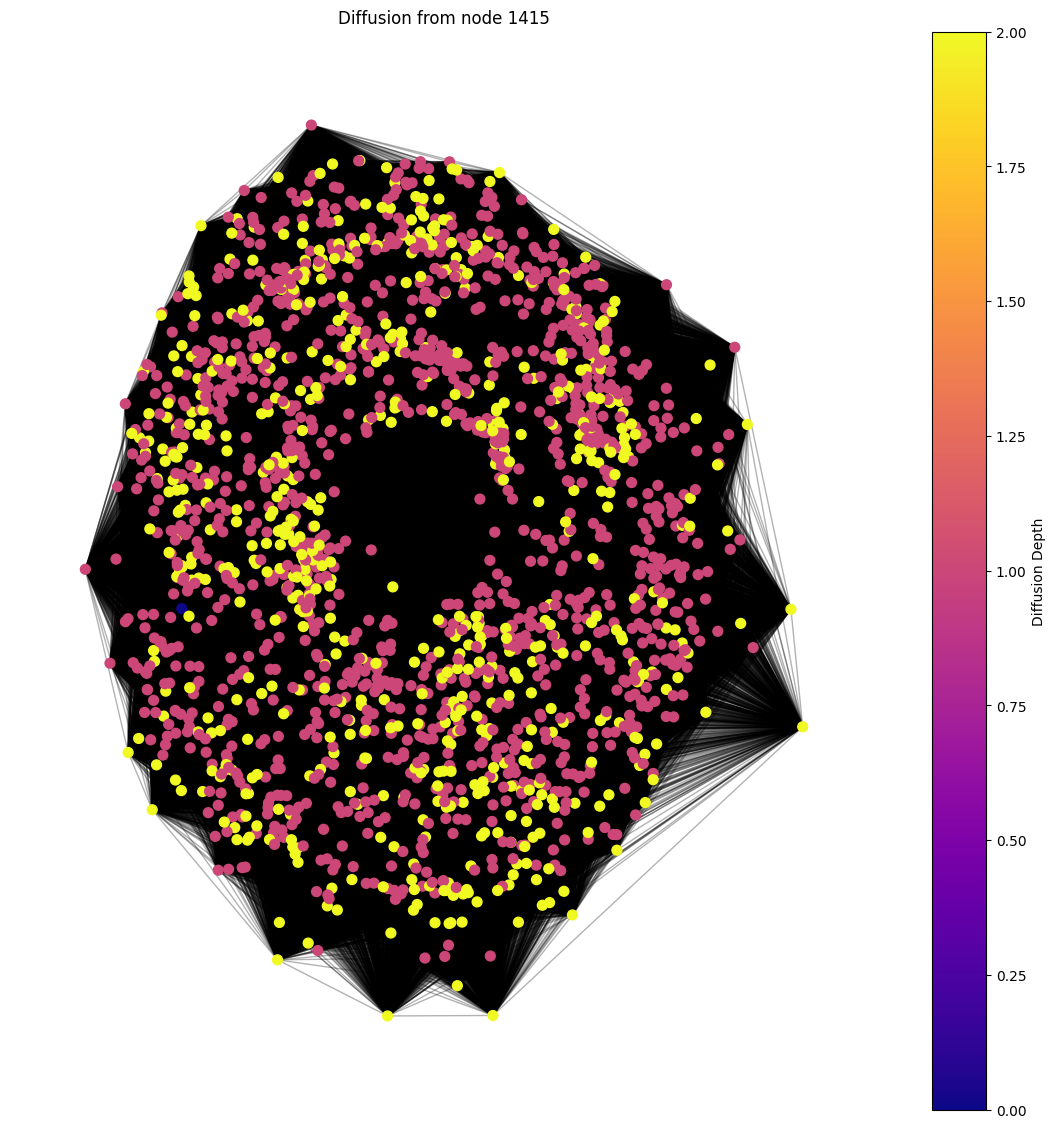

In [9]:
import random
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
from matplotlib.colors import Normalize

# Chọn một nút ngẫu nhiên làm nguồn lan truyền
start_node = random.choice(list(G.nodes))

# Lan truyền theo Breadth-First Search (BFS)
layers = dict()  # layer[node] = depth

queue = [(start_node, 0)]
visited = set()

while queue:
    current_node, depth = queue.pop(0)
    if current_node in visited:
        continue
    visited.add(current_node)
    layers[current_node] = depth
    for neighbor in G.neighbors(current_node):
        if neighbor not in visited:
            queue.append((neighbor, depth + 1))

print(f"\nTổng số nút đã được lan truyền từ nút {start_node}: {len(layers)}")
print(f"Độ sâu lớn nhất đạt được: {max(layers.values())}")

# Vẽ quá trình lan truyền
plt.figure(figsize=(14, 14))
pos = nx.spring_layout(G, seed=42)

# Màu theo layer (độ sâu)
node_colors = [layers.get(node, 0) for node in G.nodes]

# Tạo màu
cmap = cm.plasma
sm = cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm.set_array([])

# Vẽ nodes và edges
nx.draw_networkx_nodes(
    G, pos, 
    node_size=50, 
    node_color=node_colors, 
    cmap=cmap,
    vmin=min(node_colors),
    vmax=max(node_colors)
)
nx.draw_networkx_edges(G, pos, alpha=0.3)

# Thêm colorbar (fix lỗi)
cbar = plt.colorbar(sm, ax=plt.gca(), label="Diffusion Depth")

plt.title(f"Diffusion from node {start_node}")
plt.axis('off')
plt.show()


Số nút sau lọc: 907, số cạnh: 398903
Sau sampling: 100 nodes
Số cụm tìm được sau 3 lần tách: 4


C:\Users\QUYEN\AppData\Local\Temp\ipykernel_33672\1374024364.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('tab20', len(communities)),
C:\Users\QUYEN\AppData\Local\Temp\ipykernel_33672\1374024364.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=plt.cm.tab20(idx), label=f'Community {idx + 1}', s=100)


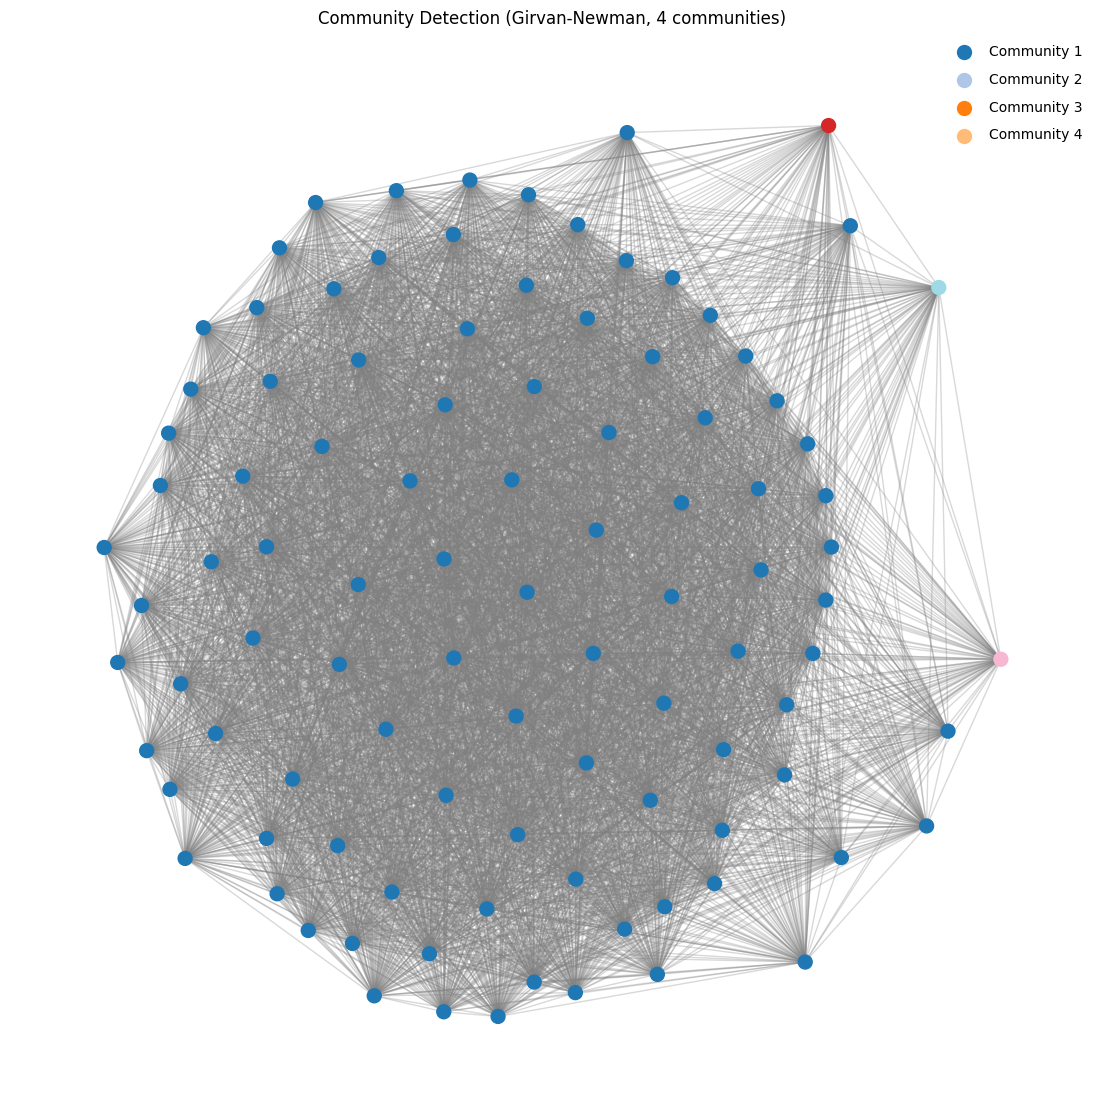

In [ ]:
from networkx.algorithms import community

# Bước 1: Lọc nút có degree > 1500 (vì đồ thị dense)
threshold_degree = 1500
nodes_high_degree = [n for n, d in G.degree() if d > threshold_degree]
G_sub = G.subgraph(nodes_high_degree).copy()

print(f"Số nút sau lọc: {len(G_sub.nodes())}, số cạnh: {len(G_sub.edges())}")

# Nếu đồ thị con còn quá lớn, lấy mẫu tiếp
if len(G_sub.nodes()) > 100:
    sampled_nodes = list(G_sub.nodes())[:100]  # lấy 100 nút đầu tiên
    G_sub = G_sub.subgraph(sampled_nodes).copy()
    print(f"Sau sampling: {len(G_sub.nodes())} nodes")

# Bước 2: Áp dụng Girvan-Newman
comp = community.girvan_newman(G_sub)

# Bước 3: Chia sâu hơn - lấy 3 lần next để có nhiều cụm hơn
level = 3  # chỉnh mức depth ở đây nếu muốn chia sâu hơn nữa
for _ in range(level):
    communities = next(comp)

communities = tuple(sorted(c) for c in communities)
print(f"Số cụm tìm được sau {level} lần tách: {len(communities)}")

# Bước 4: Ánh xạ màu
color_map = {}
for idx, com in enumerate(communities):
    for node in com:
        color_map[node] = idx

# Đảm bảo mỗi cụm màu khác nhau
colors = [color_map.get(node, 0) for node in G_sub.nodes()]

# Bước 5: Vẽ
plt.figure(figsize=(14, 14))

# Dùng layout Kamada-Kawai (mượt và cụm rõ ràng hơn)
pos_sub = nx.kamada_kawai_layout(G_sub, weight=None)

# Vẽ node
nodes = nx.draw_networkx_nodes(
    G_sub,
    pos=pos_sub,
    node_color=colors,
    cmap=plt.cm.get_cmap('tab20', len(communities)),
    node_size=100
)

# Vẽ cạnh
nx.draw_networkx_edges(
    G_sub,
    pos=pos_sub,
    alpha=0.3,  # mờ cạnh cho dễ nhìn cụm
    edge_color='gray'
)

# Thêm legend cho từng cộng đồng
for idx in range(len(communities)):
    plt.scatter([], [], c=plt.cm.tab20(idx), label=f'Community {idx + 1}', s=100)

plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='upper right')
plt.title(f"Community Detection (Girvan-Newman, {len(communities)} communities)")
plt.axis('off')
plt.show()

